In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.api as sms
import pylab
from tqdm import tqdm
%matplotlib inline

plt.style.use("dark_background")

import warnings
warnings.filterwarnings("ignore")

# Имеется AI по типу ChatGPT. Выпустили обновление, которое должно улучшить выдачу ответов и снизить кол-во нажатий на 'generate answer again' со среднего равного 0.25 до среднего значения равного 0.2 . Необходимо узнать, действительно ли оно работает.

In [2]:
size = 30000 # Кол-во уникальных юзеров данного сервиса
user_id = np.random.choice(size, size, replace=False) # Сгенерирую id пользователей
current_mean = 0.25 # Задам текущее среднее значение
shape = 2 # Форму распределение
scale = current_mean / shape # Scale, чтобы среднее было равно current_mean

gen_again = np.random.gamma(shape, scale=scale, size=size)
data = pd.DataFrame({'user_id': user_id,
                     'gen_again': gen_again})
data.head()

,user_id,gen_again
0,460,0.124969
1,27835,0.012106
2,23201,0.088635
3,11557,0.225507
4,5707,0.260319


In [3]:
data.gen_again.mean()

0.24807552627112148

count    30000.000000
mean         0.248076
std          0.175581
min          0.001164
25%          0.119757
50%          0.208400
75%          0.335156
max          1.733164
Name: gen_again, dtype: float64


<AxesSubplot:xlabel='gen_again', ylabel='Count'>

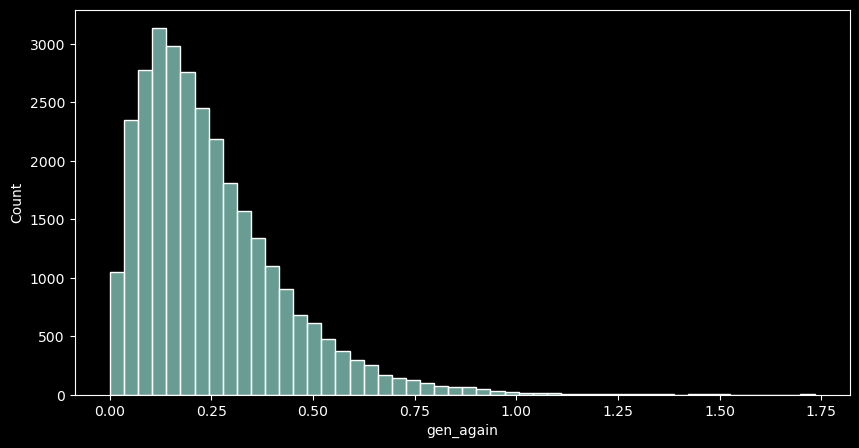

In [4]:
print(data.gen_again.describe())
plt.figure(figsize=(10, 5))
sns.histplot(data=data.gen_again, bins=50)

In [5]:
# Рассчитаю время и размер выборки необходимой для проведения A/B теста.

effect_size = sms.proportion_effectsize(0.20, 0.25)
sample_size = round(sms.NormalIndPower().solve_power(effect_size, power=0.9, alpha=0.01, ratio=1)) 

hours = round(sample_size * 2 / 200) # Время проведения теста. Пусть по условию к нам заходят 200 уникальных юзеров в час.

In [6]:
# Сделаю сплит систему и проведу A/A тест для ее проверки.

def split(uid):
    group = hash(str(uid) + 'hello') % 2
    return 'test' if group else 'control'


t_data = data.sample(5000) # Сделаю выборку, которую разобью на группы
t_data['group'] = t_data.user_id.apply(split)
control_group = t_data.query('group == "control"')
test_group = t_data.query('group == "test"')
stats.ttest_ind(control_group.gen_again, test_group.gen_again, equal_var=False)

Ttest_indResult(statistic=-0.6911524992421695, pvalue=0.4895018278657127)

Text(0.5, 1.0, 'Test Group')

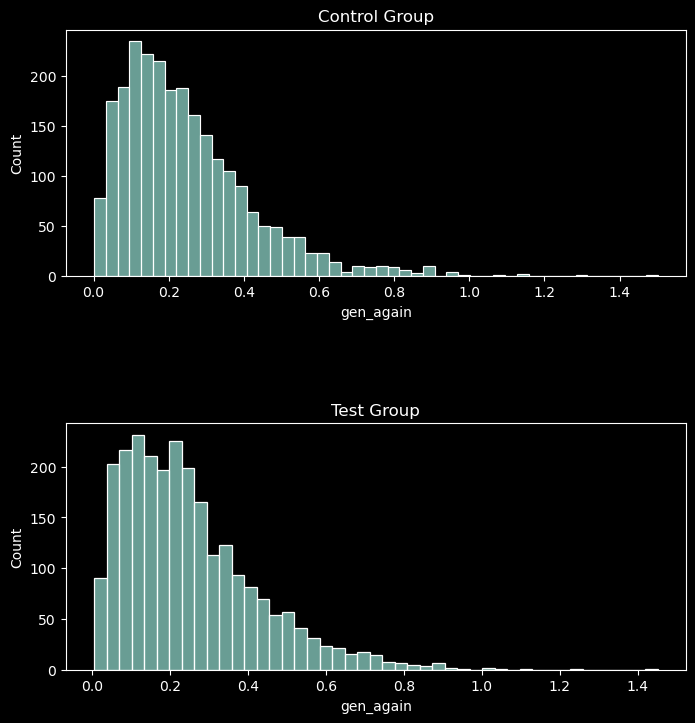

In [7]:
fig, ax = plt.subplots(nrows=2, figsize=(8,8))
plt.subplots_adjust(hspace=0.6, top=0.9, bottom=0.1)
sns.histplot(data=control_group.gen_again, ax=ax[0])
ax[0].set_title('Control Group')
sns.histplot(data=test_group.gen_again, ax=ax[1])
ax[1].set_title('Test Group')

Сплит система работает корректно. Проводим A/B test.

# Условия для применения t-test:  

1) Независимость выборок +  
2) Нормальность распределения средних. Продемонстрирую  
3) Гомогенность дисперсий. Если нет - Уэлч +  
4) Непрерывные значения +  
5) Отсутствие значительных выбросов +  
6) Выборки репрезентативны +  

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 2481.14it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

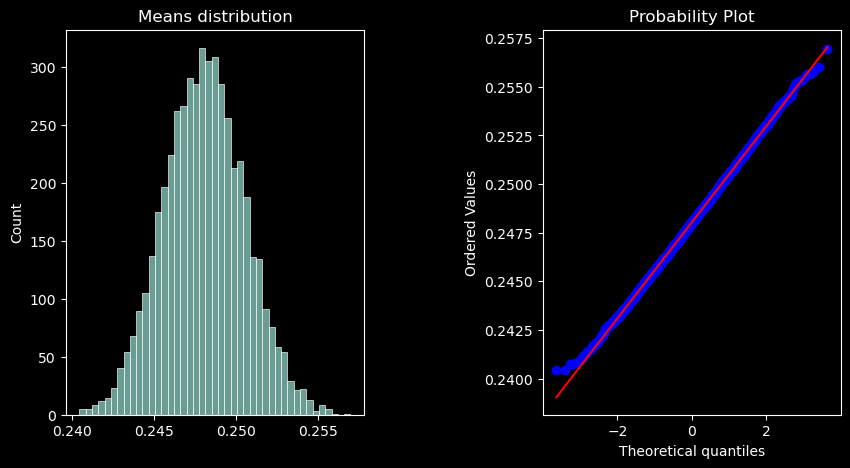

In [8]:
# Проверю распределение средних на нормальность.

means = []
for i in tqdm(range(5000)):
    means.append(data.gen_again.sample(5000, replace=True).mean())

    
fig, ax = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(wspace=0.6)
sns.histplot(data=means, ax=ax[0])
ax[0].set_title('Means distribution')
stats.probplot(means, dist='norm', plot=pylab)
plt.show

In [9]:
# Средние распределены нормально. Буду использовать Уэлч t-test. "Запускаю" A/B тест.
test_data = pd.DataFrame()
stat_result = pd.DataFrame()
stat_by_hour = pd.DataFrame()
for hour in tqdm(range(hours)):
    new_users = data.sample(200) # Зашли 200 пользователей
    new_users['hour'] = hour # Добавлю час (или дату, если на тест нужны дни)
    new_users['group'] = new_users.user_id.apply(split) # Разбиваю на группы
    
    control = new_users.query('group == "control"')
    test = new_users.query('group == "test"')
    
    test.gen_again = test.gen_again.apply(lambda x: x * np.random.uniform(0.7, 0.9)) # Симулирую эффект обновления
    
    test_data = test_data.append(control).append(test) # Собираю в один дата-фрейм
    
    t_test = stats.ttest_ind(test_data.query('group =="control"').gen_again,
                             test_data.query('group=="test"').gen_again, equal_var=False) # Проведу t-test
    
    stat_result = stat_result.append(pd.DataFrame({'t': [t_test[0]], 'p': [t_test[1]], 'hour': hour})) # Запишу результаты теста
    
    current_stat = test_data.groupby(['group'], as_index=False).agg({'gen_again': 'mean'})
    current_stat['hour'] = hour
    stat_by_hour = stat_by_hour.append(current_stat)
    

100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 116.01it/s]


<AxesSubplot:xlabel='hour', ylabel='gen_again'>

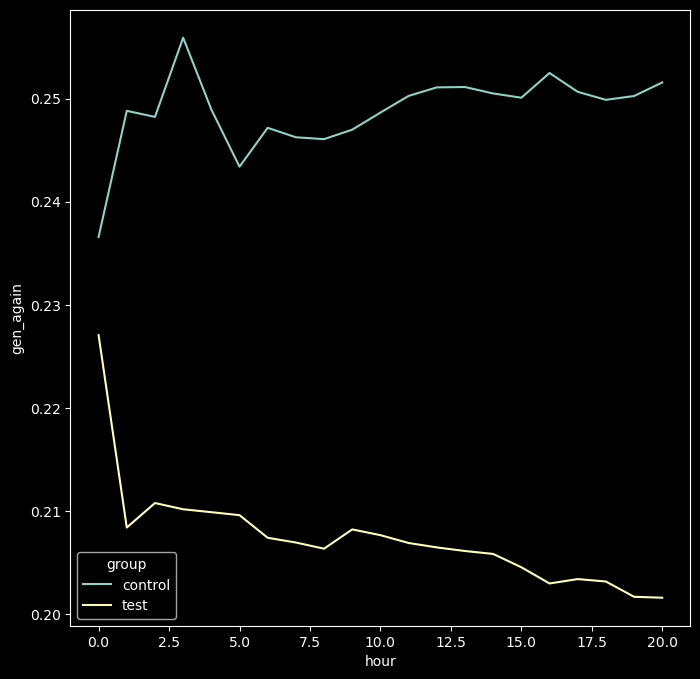

In [10]:
stat_by_hour = stat_by_hour.reset_index(drop=True)
plt.figure(figsize=(8, 8))
sns.lineplot(data=stat_by_hour, x='hour', y='gen_again', hue='group')

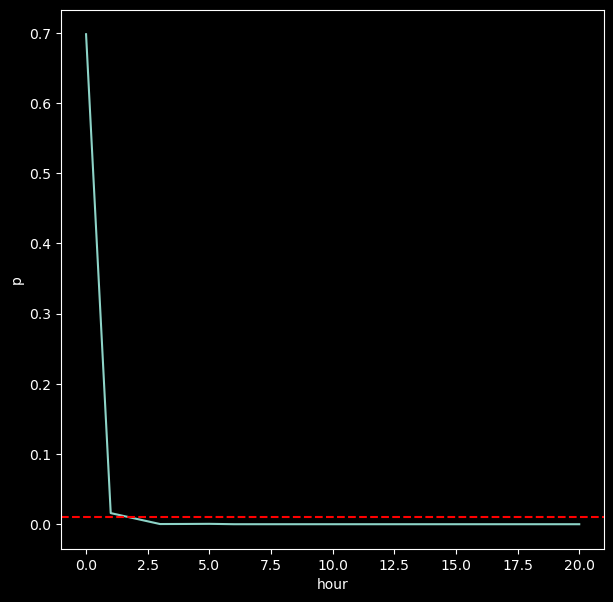

In [11]:
stat_result = stat_result.reset_index(drop=True)
plt.figure(figsize=(7, 7))
ax = sns.lineplot(data=stat_result, x="hour", y="p")
ax.axhline(0.01, ls='--', color='red')

T-test показал, что имеется статистическая значимость. Выкатываем обновление.

# Bootstrap.
Сравню две группы бутстрапом.

In [20]:
def get_bootstrap(data_column_1, data_column_2, boot_it=1000, statistic=np.mean, bootstrap_conf_level=0.95,
                  plot='on', seed=None):
    if seed:
        np.random.seed(seed)
        
    boot_len = max([len(data_column_1), len(data_column_2)])
    
    boot_data = []

    for i in range(boot_it):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(boot_len, replace=True).values
        samples_2 = data_column_2.sample(boot_len, replace=True).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = stats.norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.style.use("dark_background")
    
    if plot == 'on':
        _, _, bars = plt.hist(pd_boot_data[0], bins=50)
        for bar in bars:
            if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
                bar.set_facecolor('blue')
            else: 
                bar.set_facecolor('grey')
                bar.set_edgecolor('black')

        plt.vlines(quants, ymin=0, ymax=500, linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()
       
    return {"boot_data": boot_data, "quants": quants, "p_value": p_value}

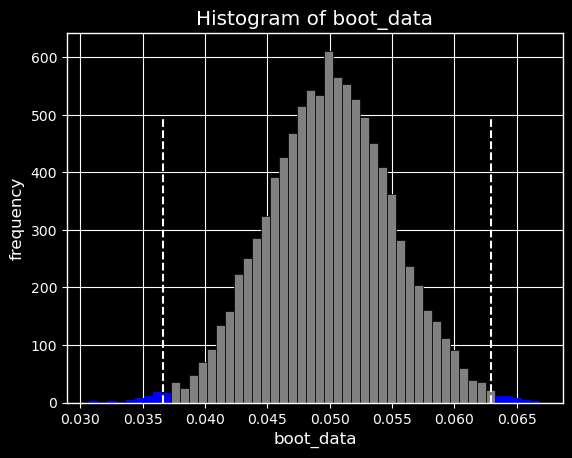

In [21]:
a = test_data.query("group == 'control'").gen_again
b = test_data.query("group == 'test'").gen_again
bootstrap = get_bootstrap(a, b, bootstrap_conf_level=0.99, boot_it=10000, seed=5)

In [22]:
bootstrap['p_value']

4.2781643768298945e-23

Бутстрап также показывает наличие статистической значимости между группами.